<a href="https://colab.research.google.com/github/KarthikPrakasham/BIgMart_LinearRegression/blob/main/Big_Mart_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
train = pd.read_csv("sample_data/train_data.csv")
test = pd.read_csv("sample_data/test_data.csv")

In [ ]:
train.shape

(8523, 12)

In [ ]:
test.shape

(5681, 11)

In [ ]:
train.isna().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

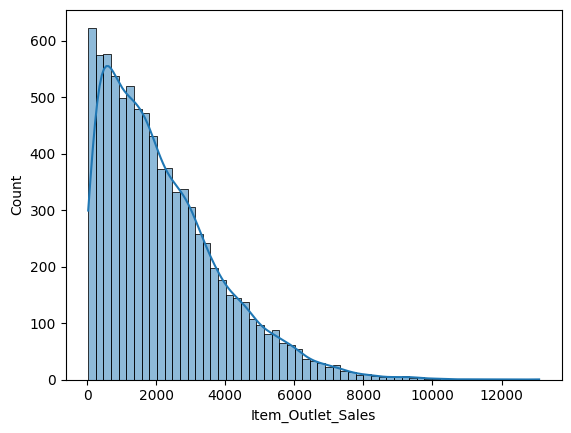

In [ ]:
sns.histplot(train['Item_Outlet_Sales'],kde = True)

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

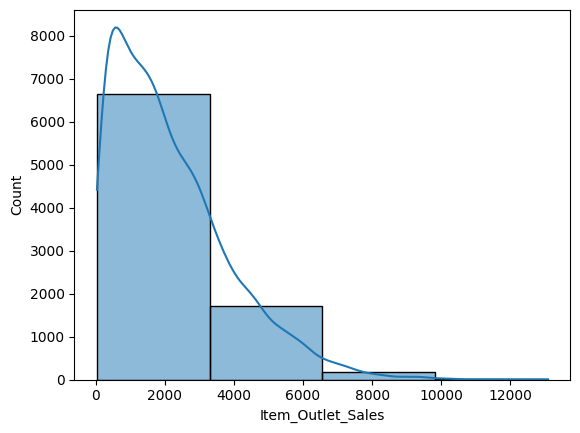

In [ ]:
sns.histplot(train['Item_Outlet_Sales'],kde = True,bins=4)

<Axes: ylabel='Item_Visibility'>

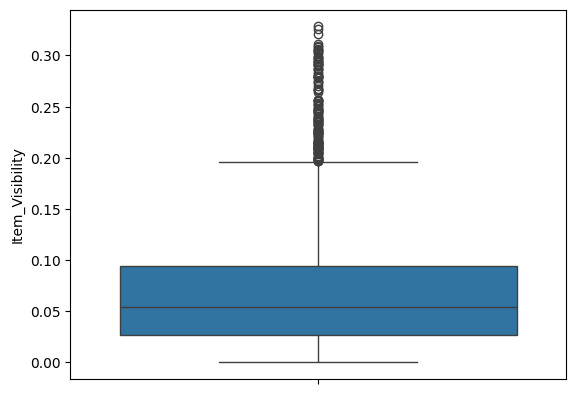

In [ ]:
sns.boxplot(train['Item_Visibility'])

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

<Axes: ylabel='Item_Weight'>

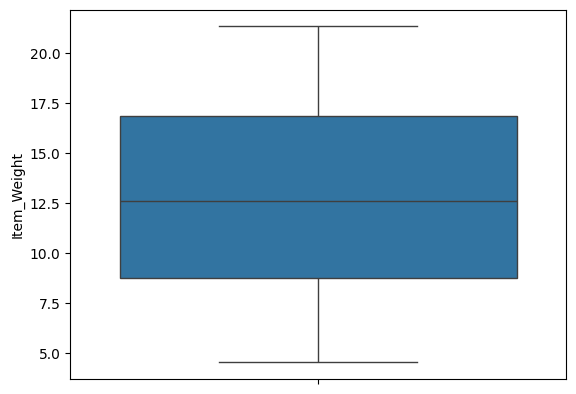

In [ ]:
sns.boxplot(train['Item_Weight'])

<Axes: ylabel='Item_MRP'>

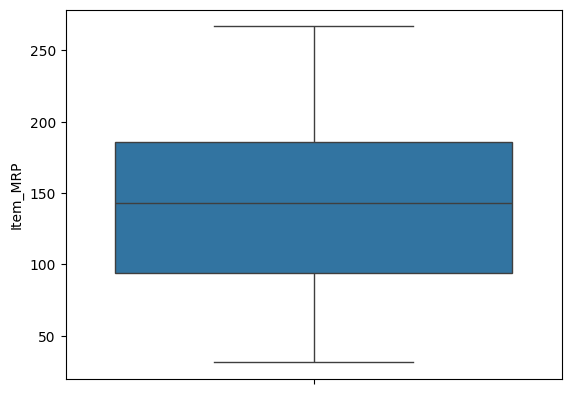

In [ ]:
sns.boxplot(train['Item_MRP'])

<Axes: ylabel='Outlet_Establishment_Year'>

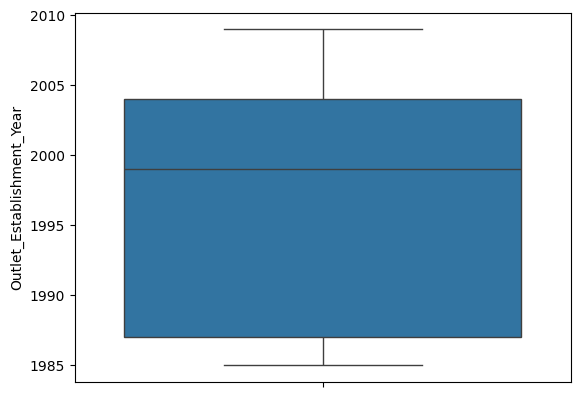

In [ ]:
sns.boxplot(train['Outlet_Establishment_Year'])

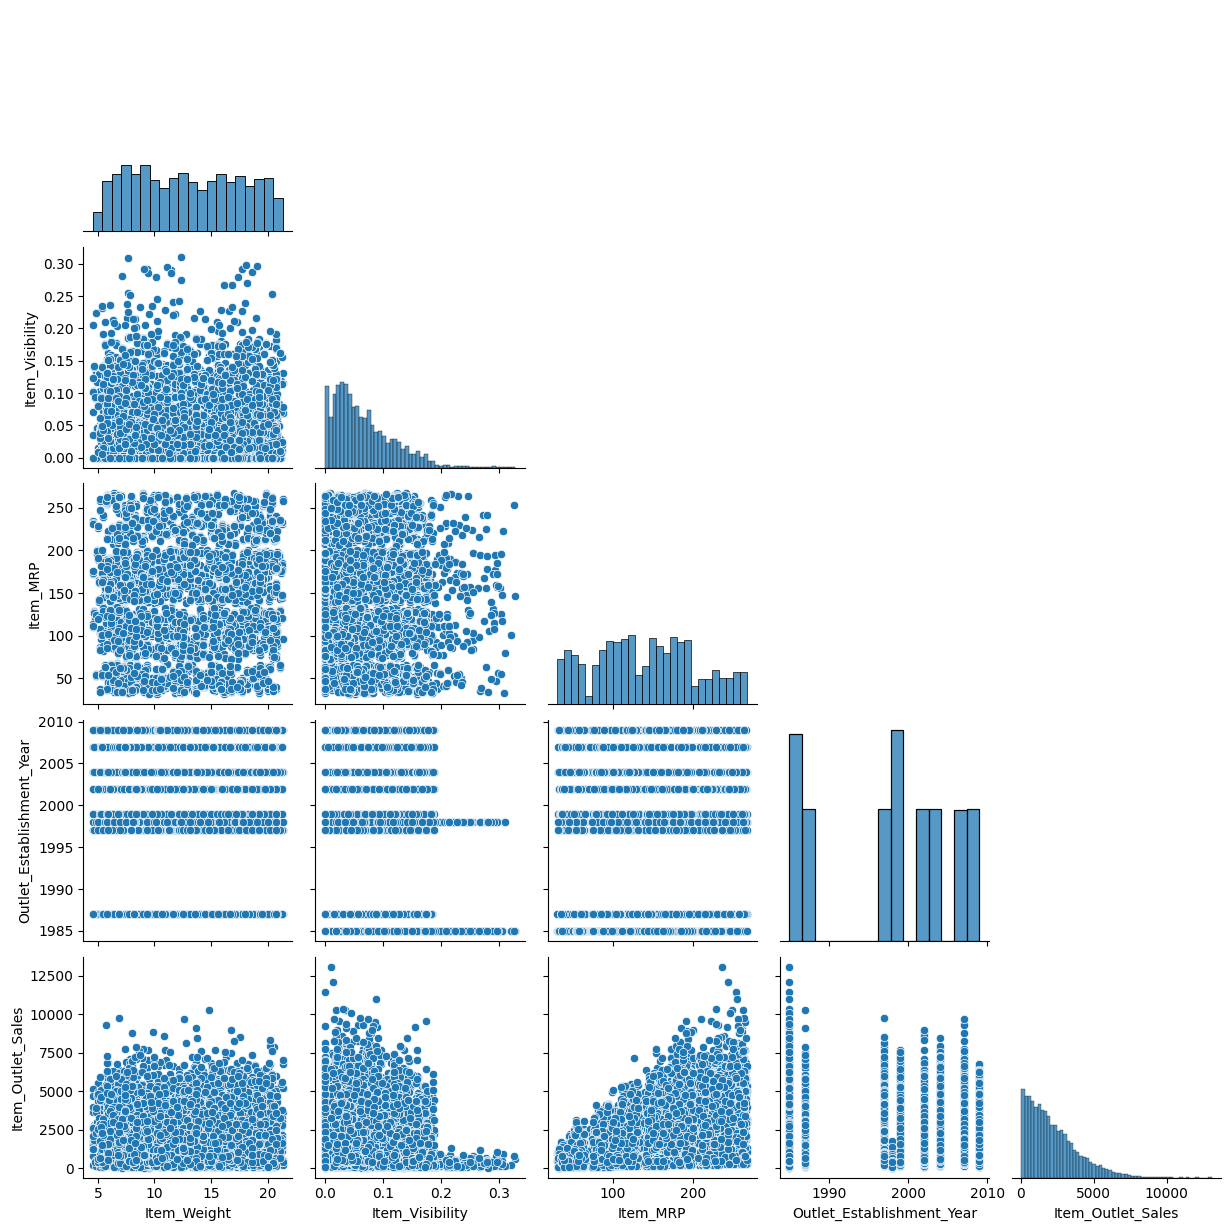

In [ ]:
sns.pairplot(train[num_cols],corner = True)

#1. Strong linear relationship (MRP-sales)
#2. Weak relationships (visibility-sales and weight-sales)
#3. Distributions along the diagonal reveal right-skewness.. WE can do log-transformations before modelling for this..

## Preprocessings:

# 1. LF - Regular fix
# 2. Itemweight - Missing values - Mean
# 3. Outlet_size - Missing values - Mode
# 4. Item_Visibility - fix 0s with Median


In [ ]:
CURRENT_YEAR = 2013
for df in [train, test]:
    # Standardize labels
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

    # Fill missing
    df['Item_Weight_Group'] = df.groupby('Item_Identifier')['Item_Weight'].transform('median')
    df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight_Group'])
    df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True) #Global Mean fix - GroupBy Appropriate categories and take group median Assignment

    df['Item_Visibility_Group'] = df.groupby(['Item_Identifier'])['Item_Visibility'].transform('median')
    df['Item_Visibility'] = np.where(df['Item_Visibility'] == 0, df['Item_Visibility_Group'], df['Item_Visibility'])
    #df['Item_Visibility'] = df['Item_Visibility'].replace(0, df['Item_Visibility'].median()) #Global Median fix - GroupBy Appropriate categories and take group median Assignment

    df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True) #Global Mode fix - GroupBy Appropriate categories and take group median Assignment
    df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_age'] = CURRENT_YEAR - df['Outlet_Establishment_Year']
    df['Visibility_MeanRatio'] = df['Item_Visibility'] / df['Item_Visibility'].mean() #Still prossible grouping but here both seem fine - Grouping by the outlet visibility
    #Categorizing item visibility - Low / High
    df['Outlet_Location_Score'] = df['Outlet_Location_Type'].map({"Tier 1":1,"Tier 2":2,"Tier 3":3})
    df['High_MRP_Flag'] = (df['Item_MRP'] > df['Item_MRP'].median()).astype(int)

    #df['Outlet_MRP_Avg'] = df.groupby('Outlet_Identifier')['Item_MRP'].transform('mean')
    #df['Relative_MRP'] = df['Item_MRP'] / df['Outlet_MRP_Avg']

In [ ]:
train.to_csv("preprocessed_train.csv", index = False)
test.to_csv("preprocessed_test.csv", index = False)

In [ ]:
#1. Ratios & interaction proportions #Both 1 or multiple columns
#2. Aggregated Statistical Features
#3. Non-Linear Transformations #optional
#4. Encoding

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()

In [ ]:
train[num_cols].corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Weight_Group,Item_Visibility_Group,Outlet_age,Visibility_MeanRatio,Outlet_Location_Score,High_MRP_Flag
Item_Weight,1.000000,-0.019432,0.025972,-0.013418,0.013165,1.000000,-0.022924,0.013418,-0.019432,0.002937,0.024839
Item_Visibility,-0.019432,1.000000,-0.004780,-0.076000,-0.127717,-0.019441,0.932219,0.076000,1.000000,-0.031468,0.004436
Item_MRP,0.025972,-0.004780,1.000000,0.005020,0.567574,0.025975,-0.005731,-0.005020,-0.004780,0.000232,0.843347
Outlet_Establishment_Year,-0.013418,-0.076000,0.005020,1.000000,-0.049135,-0.013426,0.009589,-1.000000,-0.076000,-0.089216,-0.005651
Item_Outlet_Sales,0.013165,-0.127717,0.567574,-0.049135,1.000000,0.013168,-0.010616,0.049135,-0.127717,0.089367,0.485460
Item_Weight_Group,1.000000,-0.019441,0.025975,-0.013426,0.013168,1.000000,-0.022940,0.013426,-0.019441,0.002938,0.024845
Item_Visibility_Group,-0.022924,0.932219,-0.005731,0.009589,-0.010616,-0.022940,1.000000,-0.009589,0.932219,-0.013069,0.001086
Outlet_age,0.013418,0.076000,-0.005020,-1.000000,0.049135,0.013426,-0.009589,1.000000,0.076000,0.089216,0.005651
Visibility_MeanRatio,-0.019432,1.000000,-0.004780,-0.076000,-0.127717,-0.019441,0.932219,0.076000,1.000000,-0.031468,0.004436
Outlet_Location_Score,0.002937,-0.031468,0.000232,-0.089216,0.089367,0.002938,-0.013069,0.089216,-0.031468,1.000000,-0.004603


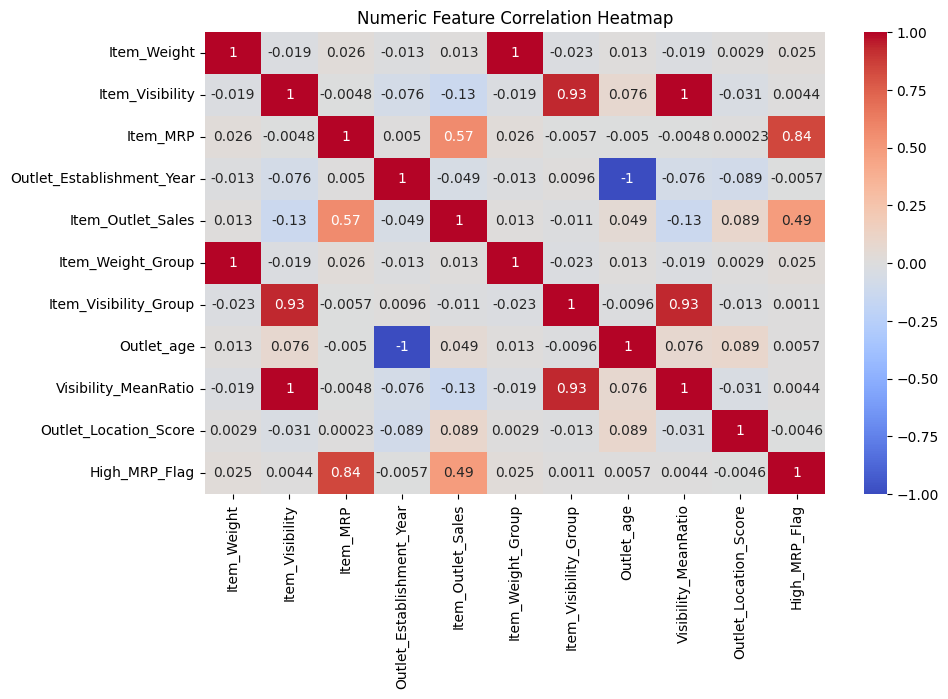

In [ ]:
num_cols = train.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [ ]:
# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["Item_Outlet_Sales"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with Item_Outlet_Sales (lower p = stronger association):")
display(chi_df)

Chi-Square association with Item_Outlet_Sales (lower p = stronger association):


,Feature,Chi2,p_value
3,Outlet_Identifier,3679.210196,0.000000e+00
6,Outlet_Type,3647.922343,0.000000e+00
0,Item_Identifier,7454.138969,1.486821e-132
5,Outlet_Location_Type,282.177067,5.372026e-58
4,Outlet_Size,119.632597,1.946431e-23
7,Item_Category,27.515132,1.159189e-04
2,Item_Type,88.372933,1.204309e-04
1,Item_Fat_Content,5.429388,1.429235e-01


In [ ]:
target = "Item_Outlet_Sales"

features = ["Item_Weight",'Item_Visibility','Item_MRP','Outlet_age','Outlet_Location_Score','Item_Type','Item_Category',
            'Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']

X = train[features]
y = train[target]

X_test = test[features]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [ ]:
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age',
       'Outlet_Location_Score'],
      dtype='object')

In [ ]:
cat_cols

Index(['Item_Type', 'Item_Category', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Outlet_Identifier'],
      dtype='object')

Predict the column: Item_outlet_sales

- ItemMRP
- Item_Visibility

Sales = B + M1 * ItemMRP + M2 * Item_visibility + M3 * Outlet AGE

Interpret:
1. For every 1 rs increase in MRP how much sales does it add..
  Eg: rs. 1 increase in MRP - Sales adds rs. 3.5


Sales:
Sales = B + 3.5(MRP) - 250(Visibility) + 20(OutletAGe)

In [ ]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat",OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())])

In [ ]:
lin_pipe.fit(X,y)
y_pred = lin_pipe.predict(X)

In [ ]:
r2 = r2_score(y,y_pred)
rmse = np.sqrt(mean_squared_error(y,y_pred))

In [ ]:
r2

0.5636142440883256

In [ ]:
rmse

np.float64(1127.2389810354182)

In [ ]:
#from sklearn.linear_model import SGDRegressor

#gd_lrmodel = SGDRegressor()
#gd_lrmodel.fit(X,y)

In [ ]:
preds = lin_pipe.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'],
                           'Outlet_Identifier':test['Outlet_Identifier'],
                           'Item_Outlet_Sales': preds})

submission.to_csv("Submission_LR_CF.csv",index=False)

In [ ]:
import joblib

joblib.dump(lin_pipe,'bigmart_model.pkl')

['bigmart_model.pkl']

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
sgd_pipe = Pipeline([('prep',preprocessor),
                     ('model',SGDRegressor(loss='squared_error',
                                           max_iter=1000))]) #Learns

In [ ]:
sgd_pipe.fit(X,y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_age',
       'Outlet_Location_Score'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['Item_Type', 'Item_Category', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Outlet_Identifier'],
      dtype='object'))])),
                ('model', SGDRegressor())])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y,sgd_pipe.predict(X)))
r2 = r2_score(y,sgd_pipe.predict(X))

In [ ]:
rmse

np.float64(1128.4324409472092)

In [ ]:
preds = sgd_pipe.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'],
                           'Outlet_Identifier':test['Outlet_Identifier'],
                           'Item_Outlet_Sales': preds})

submission.to_csv("Submission_LR_SGD.csv",index=False)